In this notebook we train models to predict issue labels and test which models are effective. The basic flow of the notebook is such: one reads in the data, examines it and sets some parameters such as ignored labels, then trains both a SVM and fastText model as a binary classification task on each label. Negative samples are taken evenly throughout the other labels. Whichever labels' models perform better than some specified benchmark are then trained on the whole dataset and saved to Ceph. A text file is saved containing which labels' models are saved that a Flask app will then perform inference on.

#### First we import packages, set up our Ceph client, and read in the data.

In [84]:
import pandas as pd
import numpy as np
from skift import FirstColFtClassifier
import itertools
import collections
import os
import seaborn as sns
from sklearn.model_selection import KFold
import boto3
from dotenv import load_dotenv, find_dotenv
import sys
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from joblib import dump

sys.path.append("../src/data")  # noqa
from preprocess import process  # noqa

In [40]:
# load environment variables
load_dotenv(find_dotenv())

True

In [41]:
# whether to use ceph or store locally

use_ceph = True

if use_ceph:
    s3_endpoint_url = os.environ["OBJECT_STORAGE_ENDPOINT_URL"]
    s3_access_key = os.environ["AWS_ACCESS_KEY_ID"]
    s3_secret_key = os.environ["AWS_SECRET_ACCESS_KEY"]
    s3_bucket = os.environ["OBJECT_STORAGE_BUCKET_NAME"]

    s3 = boto3.client(
        service_name="s3",
        aws_access_key_id=s3_access_key,
        aws_secret_access_key=s3_secret_key,
        endpoint_url=s3_endpoint_url,
    )

In [42]:
name = os.getenv("REPO_NAME")

if "/" in name:
    REPO = name
    USER = ""
else:
    USER = name
    REPO = ""

In [43]:
# repo data is saved as {org_name}-_-{repo_name}
# orginization data is saved as {org_name}

savename = USER if USER else REPO.replace("/", "-_-")
path = os.path.join("../data", savename + ".csv")
key = f"github-labeler/data/{savename}.csv"

if use_ceph:
    response = s3.get_object(Bucket=s3_bucket, Key=key)
    issues_df = pd.read_csv(response.get("Body")).drop_duplicates()
else:
    issues_df = pd.read_csv(path).drop_duplicates()

In [44]:
issues_df.sample(5)

,id,repo,title,body,created_at,created_by,num_labels,labels
8591,openshift/origin/19034,openshift/origin,"oc cluster up fails for v3.9.0, works for v3.9...",<!--\r\nNote that this is the issue tracker fo...,2018-03-20 15:20:13,pilhuhn,4,kind/bug\tpriority/P2\tsig/master\tsig/user-in...
9192,openshift/origin/20938,openshift/origin,Can't create persistent firewalld rules to blo...,I can create persistent rules to block incomin...,2018-09-11 23:07:14,soukron,2,lifecycle/rotten\tsig/networking
6129,openshift/origin/13097,openshift/origin,test/end-to-end/core.sh:385: executing oc get ...,Seen in https://ci.openshift.redhat.com/jenkin...,2017-02-24 10:07:43,soltysh,3,component/apps\tkind/test-flake\tpriority/P2
7855,openshift/origin/17187,openshift/origin,Network connectivity flake during GCE installa...,https://openshift-gce-devel.appspot.com/build/...,2017-11-04 23:36:35,smarterclayton,4,component/install\tcomponent/networking\tlifec...
689,openshift/origin/2500,openshift/origin,router status handler should not use a hardcod...,https://github.com/openshift/origin/blob/maste...,2015-05-26 17:02:10,brenton,3,area/security\tkind/bug\tpriority/P1


#### Here we examine the labels a bit. We can define any labels that are synonyms and define bots whose issues we don't want to include

In [45]:
# outputwith all labels more samples than "cutoff", in order.

cutoff = 0

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")

priority/P2 3510
kind/bug 1868
lifecycle/rotten 1788
priority/P3 1388
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 749
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 486
component/kubernetes 392
component/imageregistry 324
component/networking 323
lifecycle/stale 308
component/auth 299
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 174
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 115
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52


In [46]:
# define synonyms, first in set will be used name

synsets = [
    ["kind/bug", "bug"],
]

In [47]:
# equate synonyms

for syn in synsets:

    def equate_syns(lbl):
        return syn[0] if lbl in syn[1:] else lbl

    def equate_list(lbllist):
        if type(lbllist) == str:
            return "\t".join(
                list(set([equate_syns(lbl) for lbl in lbllist.split("\t")]))
            )
        else:
            return lbllist

    issues_df.labels = issues_df.labels.apply(equate_list)

(0.0, 6.0)

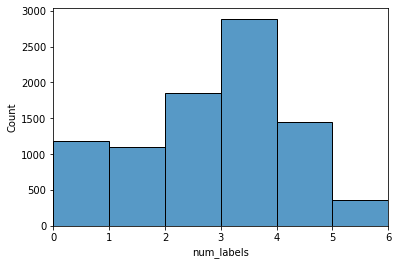

In [48]:
# output histogram of number of labels

ax = sns.histplot(issues_df.num_labels, bins=int(max(issues_df.num_labels)))
ax.set_xlim((0, 6))

In [49]:
# view most common issue creators

issues_df.created_by.value_counts(ascending=False).head(10)

smarterclayton    768
deads2k           374
kargakis          362
spadgett          349
bparees           297
liggitt           276
stevekuznetsov    273
mfojtik           256
soltysh           139
sosiouxme         108
Name: created_by, dtype: int64

In [50]:
# first find bots transparently tagged as such


def is_bot(name):
    return name[-5:] == "[bot]"


all_names = issues_df.created_by.unique()

bots = all_names[[is_bot(x) for x in all_names]]

print("bots found:")
for b in bots:
    print("\t", b)

bots found:


In [51]:
# choose any additional bot accounts whose issues to not count

additional_bots = ["sesheta"]

In [52]:
# filter out issues created by bots & their labels

bots = np.concatenate((bots, additional_bots))

issues_df = issues_df[issues_df.created_by.apply(lambda x: x not in bots)]

In [53]:
# most popular labels, nearly finalized

cutoff = 50
final_labels = []

label_lst = list(
    itertools.chain.from_iterable([ls.split("\t") for ls in issues_df.labels.dropna()])
)
counter = collections.Counter(label_lst)

for a, b in counter.most_common():
    if b > cutoff:
        print(f"{a} {b}")
        final_labels.append(a)

priority/P2 3510
kind/bug 1868
lifecycle/rotten 1788
priority/P3 1388
priority/P1 1215
kind/test-flake 1085
component/cli 873
kind/question 749
area/usability 655
component/build 648
component/web 637
area/tests 599
component/apps 486
component/kubernetes 392
component/imageregistry 324
component/networking 323
lifecycle/stale 308
component/auth 299
sig/master 298
area/techdebt 294
component/routing 245
component/restapi 208
area/security 197
priority/P0 197
component/storage 187
component/internal-tools 174
component/install 169
lifecycle/frozen 163
sig/developer-experience 163
kind/post-rebase 153
component/composition 145
component/image 135
sig/security 125
sig/networking 118
area/documentation 115
area/performance 101
component/cluster-up 101
area/infrastructure 83
component/logging 75
sig/pod 69
help wanted 67
sig/storage 66
component/metrics 65
kind/feature 55
component/containers 52


#### Here we can choose some labels that will discard an issue entirely from the dataset (e.g. 'bot' label), and we can choose some labels which we do not want to train a model to predict.

In [54]:
# choose labels whose issues you don't want to include in the dset (for either positive or negative sampling)

exclude = []

In [55]:
# remove those labels

for lbl in exclude:
    if lbl in final_labels:
        final_labels.remove(lbl)


def inclusion(lbl_list):
    if type(lbl_list) == str:
        return not any([lbl in lbl_list.split("\t") for lbl in exclude])
    else:
        return True


not_containing = issues_df.labels.apply(lambda x: inclusion(x))
issues_df = issues_df[not_containing]

In [56]:
# choose issues you do not wish to attempt to predict

dont_pred = [
    "priority/P2",
    "lifecycle/frozen",
    "lifecycle/stale",
    "priority/P3",
    "priority/P1",
    "lifecycle/rotten" "priority/P0",
    "lifecycle/rotten",
]

for dp in dont_pred:
    if dp in final_labels:
        final_labels.remove(dp)
    else:
        continue

(0.0, 6.0)

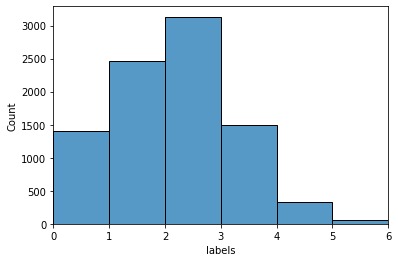

In [57]:
# output histogram of number of relevant labels, finalized

set_dp = set(dont_pred)

num_rel_issues = issues_df.labels.apply(
    lambda x: len(set(x.split("\t")).difference(set_dp)) if type(x) == str else 0
)

ax = sns.histplot(num_rel_issues, bins=int(max(num_rel_issues)))
ax.set_xlim((0, 6))

In [58]:
# preprocess text

issues_df["processed"] = issues_df.apply(
    lambda row: np.array(process(row["title"], row["body"])), axis=1
)

In [59]:
# hacky way to make tfidf work on also tokenized text


def dummy_fun(doc):
    return doc


tfidf = TfidfVectorizer(
    analyzer="word", tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None
)

tfidf.fit(issues_df.processed.values)

CountVectorizer(preprocessor=<function dummy_fun at 0x7feb1bfe14c0>,
                token_pattern=None,
                tokenizer=<function dummy_fun at 0x7feb1bfe14c0>)

In [60]:
def get_subdataset(label):
    """
    pass in a label name and get back a dataframe of positive & negative samples for the label
    we avoid taking unlabelled data as negative samples
    negative samples are distributed evenly amongst the other labels
    """
    labelled = issues_df[~issues_df.labels.isna()]
    final_labels_ = final_labels.copy()
    final_labels_.remove(label)
    pos_samples = labelled[labelled.labels.apply(lambda x: label in x.split("\t"))]
    n = len(pos_samples)
    remaining = labelled[labelled.id.apply(lambda x: label not in x.split("\t"))]
    n_neg = 0
    per_label = n // len(final_labels_)
    neg_ids = set()
    # evenly sample if we can
    # if not enough samples for a label, throw them all in and increase the remaining amount we need per label
    for i, lbl in enumerate(reversed(final_labels_)):
        neg_samples = remaining[remaining.labels.apply(lambda x: lbl in x.split("\t"))]
        if len(neg_samples) >= per_label:
            neg_samples = neg_samples.sample(per_label)
            n_neg += per_label
        else:
            n_neg += len(neg_samples)
            if i != len(final_labels_) - 1:
                per_label = (n - n_neg) // (len(final_labels_) - i - 1)
        remaining = remaining[
            remaining.labels.apply(lambda x: lbl not in x.split("\t"))
        ]
        neg_ids = neg_ids.union(set(neg_samples.id))
    # fill in potential gap with unlabelled issues, if needed
    if len(pos_samples) > len(neg_ids):
        unlabelled = issues_df.query("num_labels == 0")
        if len(unlabelled) > len(pos_samples) - len(neg_ids):
            neg_ids = neg_ids.union(
                set(unlabelled.sample(len(pos_samples) - len(neg_ids)).id)
            )
        else:
            neg_ids = neg_ids.union(set(unlabelled.ids))
            pos_samples = pos_samples.sample(len(neg_ids))
    final_neg_samples = issues_df[issues_df.id.apply(lambda x: x in neg_ids)]
    x = pd.concat((final_neg_samples, pos_samples))
    y = np.concatenate((np.zeros(len(final_neg_samples)), np.ones(len(pos_samples))))
    return x, y.astype(int)

In [86]:
class FtModel(FirstColFtClassifier):
    def __init__(self):
        super().__init__()

    def preprocess(self, x):
        ret = np.array(x.processed.apply(lambda x: " ".join(x))).reshape(-1, 1)
        return ret

    def fit(self, x, y):
        input_ = self.preprocess(x)
        super().fit(input_, y)

    def predict(self, x):
        input_ = self.preprocess(x)
        return super().predict(input_)

    def save(self, path):
        return self.model.save_model(path)


class SVM(SVC):
    def __init__(self):
        super().__init__()

    def preprocess(self, x):
        ret = tfidf.transform(x.processed)
        return ret

    def fit(self, x, y):
        input_ = self.preprocess(x)
        super().fit(input_, y)

    def predict(self, x):
        input_ = self.preprocess(x)
        return super().predict(input_)

    def save(self, path):
        return dump(self, path)

In [62]:
def predict_label(label, k=5, model_class=FtModel):
    """
    validates fastText model on the given label, using k-fold cross validation
    """
    x, y = get_subdataset(label)
    kf = KFold(n_splits=k, random_state=None, shuffle=True)
    accuracy = []
    precision = []
    recall = []
    for train_index, test_index in kf.split(x):
        model = model_class()
        x_train, x_test = x.iloc[train_index], x.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
        accuracy.append(np.mean(preds == y_test))
        precision_ = preds[preds == 1] == y_test[preds == 1]
        if len(precision_) != 0:
            precision.append(np.mean(precision_))
        recall_ = preds[y_test == 1] == y_test[y_test == 1]
        if len(recall_) != 0:
            recall.append(np.mean(recall_))
    cols = ["label", "n", "accuracy", "precision", "recall"]
    data = [label, len(x), np.mean(accuracy), np.mean(precision), np.mean(recall)]
    return pd.DataFrame([data], columns=cols)

In [68]:
predicted_labels = []
for label in final_labels:
    pred_1 = predict_label(label, model_class=FtModel)
    pred_2 = predict_label(label, model_class=SVM)
    pred_1["model"] = "ft"
    pred_2["model"] = "svm"
    if pred_1.iloc[0].accuracy > (pred_2.iloc[0].accuracy):
        predicted_labels.append(pred_1)
    else:
        predicted_labels.append(pred_2)

/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/app-root/lib64/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/app-root/lib64/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [69]:
# save and print the validation results

results_df = pd.concat(predicted_labels).sort_values("n", ascending=False)

results_df

,label,n,accuracy,precision,recall,model
0,kind/bug,3736,0.564504,0.553950,0.747252,ft
0,lifecycle/rotten,3576,0.549215,0.550906,0.529597,svm
0,kind/test-flake,2170,0.855760,0.823614,0.905965,svm
0,component/cli,1746,0.719379,0.713212,0.734880,svm
0,kind/question,1498,0.710925,0.702729,0.733370,svm
0,area/usability,1310,0.714504,0.704225,0.739523,svm
0,component/build,1296,0.804045,0.831148,0.763984,svm
0,component/web,1274,0.806901,0.810305,0.808636,svm
0,area/tests,1198,0.811342,0.820906,0.796204,svm
0,component/apps,972,0.807650,0.896901,0.699391,svm


In [74]:
# set conditions for saving the model of a potential label

min_accuracy = 0.75

min_precision = 0.75

min_recall = 0.0

# add in the labels you want to have a model for anyway

addins = ["kind/bug"]

condition1 = results_df.accuracy > min_accuracy
condition2 = results_df.precision > min_precision
cond = condition1 & condition2

to_save = results_df[cond | results_df.label.isin(addins)]

labels_to_save = to_save[["label", "model"]].values

to_save

,label,n,accuracy,precision,recall,model
0,kind/bug,3736,0.564504,0.553950,0.747252,ft
0,kind/test-flake,2170,0.855760,0.823614,0.905965,svm
0,component/build,1296,0.804045,0.831148,0.763984,svm
0,component/web,1274,0.806901,0.810305,0.808636,svm
0,area/tests,1198,0.811342,0.820906,0.796204,svm
0,component/apps,972,0.807650,0.896901,0.699391,svm
0,component/imageregistry,648,0.823936,0.869830,0.759236,svm
0,area/techdebt,588,0.785673,0.757858,0.838984,svm
0,component/routing,490,0.875510,0.929415,0.811254,svm
0,component/storage,374,0.762270,0.832795,0.655424,svm


In [75]:
use_ceph = True

In [76]:
labels_to_save

array([['kind/bug', 'ft'],
       ['kind/test-flake', 'svm'],
       ['component/build', 'svm'],
       ['component/web', 'svm'],
       ['area/tests', 'svm'],
       ['component/apps', 'svm'],
       ['component/imageregistry', 'svm'],
       ['area/techdebt', 'svm'],
       ['component/routing', 'svm'],
       ['component/storage', 'svm'],
       ['kind/post-rebase', 'svm'],
       ['component/composition', 'svm'],
       ['component/cluster-up', 'svm'],
       ['component/logging', 'svm'],
       ['sig/storage', 'svm']], dtype=object)

In [87]:
if not os.path.exists("./saved_models"):
    os.mkdir("./saved_models")

if not os.path.exists(f"./saved_models/{savename}"):
    os.mkdir(f"./saved_models/{savename}")

model_dic = {"svm": SVM, "ft": FtModel}

if use_ceph:
    for label, model in labels_to_save:
        X, y = get_subdataset(label)
        model = model_dic[model]()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_"))
        lbl_path += ".bin" if model == "ft" else ".joblib"
        model.save(lbl_path)
        key = f"github_labeler/{savename}/{lbl_path}"
        s3.upload_file(Bucket=s3_bucket, Key=key, Filename=lbl_path)
        os.remove(lbl_path)
else:
    for label in labels_to_save:
        X, y = get_subdataset(label)
        model = model_dic[model]()
        model.fit(X, y)
        lbl_path = os.path.join("saved_models", label.replace("/", "_"))
        lbl_path += ".bin" if model == "ft" else ".joblib"
        model.save(lbl_path)

In [88]:
# save information of who to ignore (so the app knows not to tag these issues)

with open("botlist.txt", "w") as f:
    for b in bots:
        f.write(b)
        f.write("\n")

# save label names

with open("labellist.txt", "w") as f:
    for label, model in labels_to_save:
        f.write(label + "\t" + model)
        f.write("\n")

if use_ceph:
    s3.upload_file(
        Bucket=s3_bucket,
        Key=f"github_labeler/{savename}/botlist.txt",
        Filename="botlist.txt",
    )
    s3.upload_file(
        Bucket=s3_bucket,
        Key=f"github_labeler/{savename}/labellist.txt",
        Filename="labellist.txt",
    )